In [1]:
import os
import torch
import numpy as np
import pandas as pd

from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torch
import matplotlib.pyplot as plt
from torchvision import transforms, models
# import albumentations as A
# from albumentations.pytorch import ToTensorV2

# For reproducibility
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)

In [2]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [3]:
# Set constants
train_csv_path = "/kaggle/input/ai-vs-human-generated-dataset/train.csv"
test_csv_path = "/kaggle/input/ai-vs-human-generated-dataset/test.csv"
main_dir = "/kaggle/input/ai-vs-human-generated-dataset"

In [4]:
# Read Training & Test CSV File
train_csv = pd.read_csv(train_csv_path, index_col=0)
test_csv = pd.read_csv(test_csv_path, index_col=0)

# Quick Look
train_csv.head()

,file_name,label
0,train_data/a6dcb93f596a43249135678dfcfc17ea.jpg,1
1,train_data/041be3153810433ab146bc97d5af505c.jpg,0
2,train_data/615df26ce9494e5db2f70e57ce7a3a4f.jpg,1
3,train_data/8542fe161d9147be8e835e50c0de39cd.jpg,0
4,train_data/5d81fa12bc3b4cea8c94a6700a477cf2.jpg,1


In [5]:
# Testing CSV Quick look
test_csv.head()

""
id
test_data_v2/1a2d9fd3e21b4266aea1f66b30aed157.jpg
test_data_v2/ab5df8f441fe4fbf9dc9c6baae699dc7.jpg
test_data_v2/eb364dd2dfe34feda0e52466b7ce7956.jpg
test_data_v2/f76c2580e9644d85a741a42c6f6b39c0.jpg
test_data_v2/a16495c578b7494683805484ca27cf9f.jpg


In [6]:
# Size of training and testing data
print(f"Number of training samples: {train_csv.shape[0]}")
print(f"Number of testing samples : {test_csv.shape[0]}")

Number of training samples: 79950
Number of testing samples : 5540


In [7]:
for i in range(10):
    shape = plt.imread(f'{main_dir}/{train_csv.file_name[i]}').shape
    print(f"Shape of the Image: {shape}")

Shape of the Image: (768, 512, 3)
Shape of the Image: (768, 512, 3)
Shape of the Image: (512, 768, 3)
Shape of the Image: (512, 768, 3)
Shape of the Image: (768, 512, 3)
Shape of the Image: (768, 512, 3)
Shape of the Image: (512, 768, 3)
Shape of the Image: (512, 768, 3)
Shape of the Image: (528, 768, 3)
Shape of the Image: (528, 768, 3)


In [8]:
# Collect Training image paths
image_paths, image_labels = train_csv.file_name, train_csv.label

In [9]:
# Define split sizes (80% train, 10% val, 10% test)
total_size = len(image_paths)
train_size = int(0.8 * total_size)
val_size = int(0.1 * total_size)
test_size = int(0.1 * total_size)

print(f"Training Data   : {train_size}")
print(f"Testing Data    : {test_size}")
print(f"Validation Data : {val_size}")

Training Data   : 63960
Testing Data    : 7995
Validation Data : 7995


In [10]:
train_paths, train_labels = image_paths[:train_size], image_labels[:train_size]
val_paths, val_labels = image_paths[train_size:train_size+val_size], image_labels[train_size:train_size+val_size]
test_paths, test_labels = image_paths[train_size+val_size:], image_labels[train_size+val_size:]

# Data Augmentation

In [11]:
from torchvision import transforms

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.3),
    transforms.RandomRotation(90),
    # transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.2, hue=0.2),
    # transforms.GaussianBlur(kernel_size=(3, 3), sigma=(0.1, 2.0)),
    # transforms.ToTensor(),
    # transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  
    transforms.ToTensor(),        
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
    
])

val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
])

In [12]:
class ImageDataset(Dataset):
    def __init__(self, file_paths, labels, root_dir, transform=None):
        self.file_paths = file_paths
        self.labels = labels
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.file_paths.iloc[idx])
        image = Image.open(img_path).convert("RGB")  # Use PIL
        label = torch.tensor(self.labels.iloc[idx], dtype=torch.float32)

        if self.transform:
            image = self.transform(image)  # Apply torchvision transforms

        return image, label

In [13]:
BATCH_SIZE = 8

# Create datasets
train_dataset = ImageDataset(train_paths, train_labels, main_dir, transform=train_transform)
val_dataset   = ImageDataset(val_paths, val_labels, main_dir, transform=val_test_transform)
test_dataset  = ImageDataset(test_paths, test_labels, main_dir, transform=val_test_transform)

# Create loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
val_loader   = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_loader  = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

In [14]:
def show_images(loader, n_rows=4, n_cols=5):
    images, labels = next(iter(loader))
    images = images.permute(0, 2, 3, 1)  # (B, C, H, W) -> (B, H, W, C)
    plt.figure(figsize=(15, 10))
    for i in range(min(n_rows * n_cols, len(images))):
        plt.subplot(n_rows, n_cols, i + 1)
        img = images[i].numpy()
        img = (img * 0.5) + 0.5  # Unnormalize if using Normalize(mean=0.5, std=0.5)
        plt.imshow(img)
        plt.axis('off')
        plt.title("AI" if labels[i].item() == 1.0 else "Human")
    plt.show()

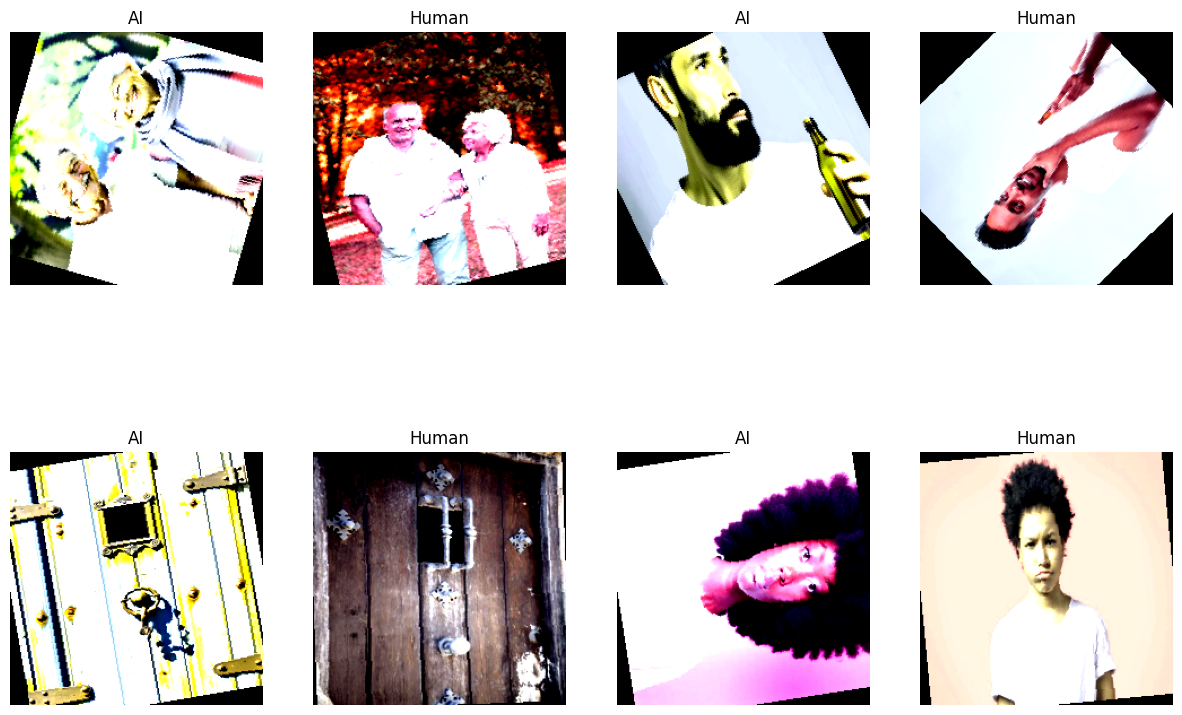

In [15]:
# Visualize Images
show_images(train_loader, n_rows=2, n_cols=4)

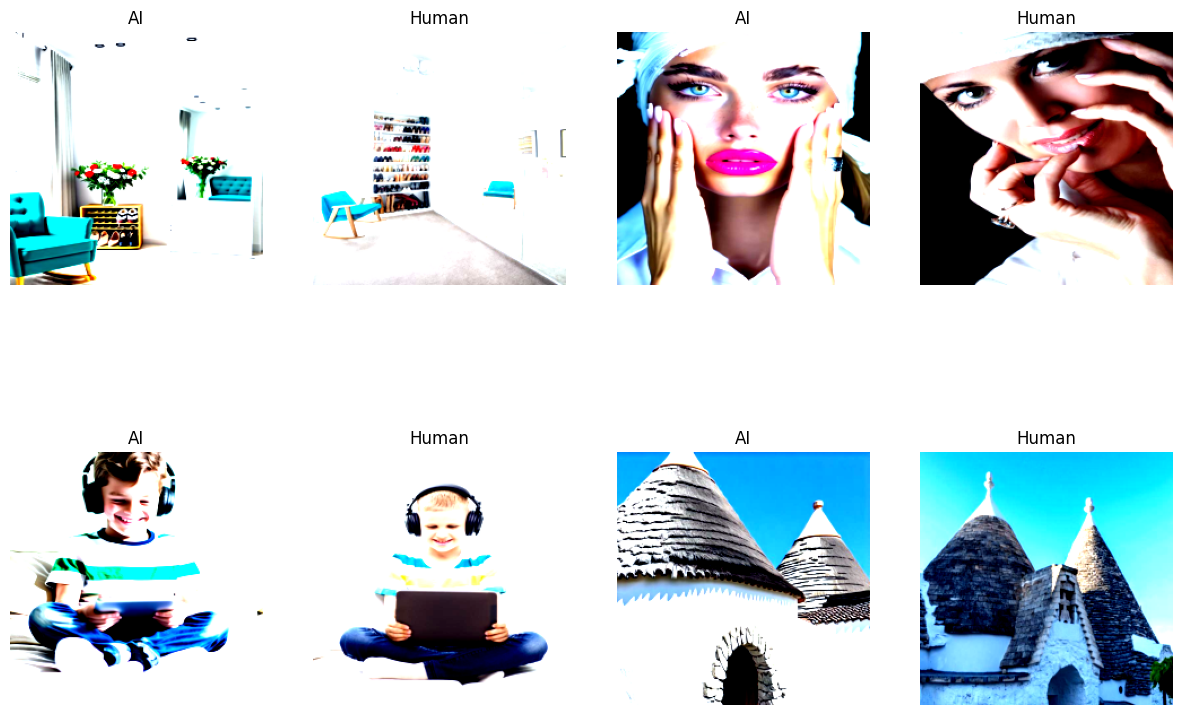

In [16]:
# Visualize Images
show_images(val_loader, n_rows=2, n_cols=4)

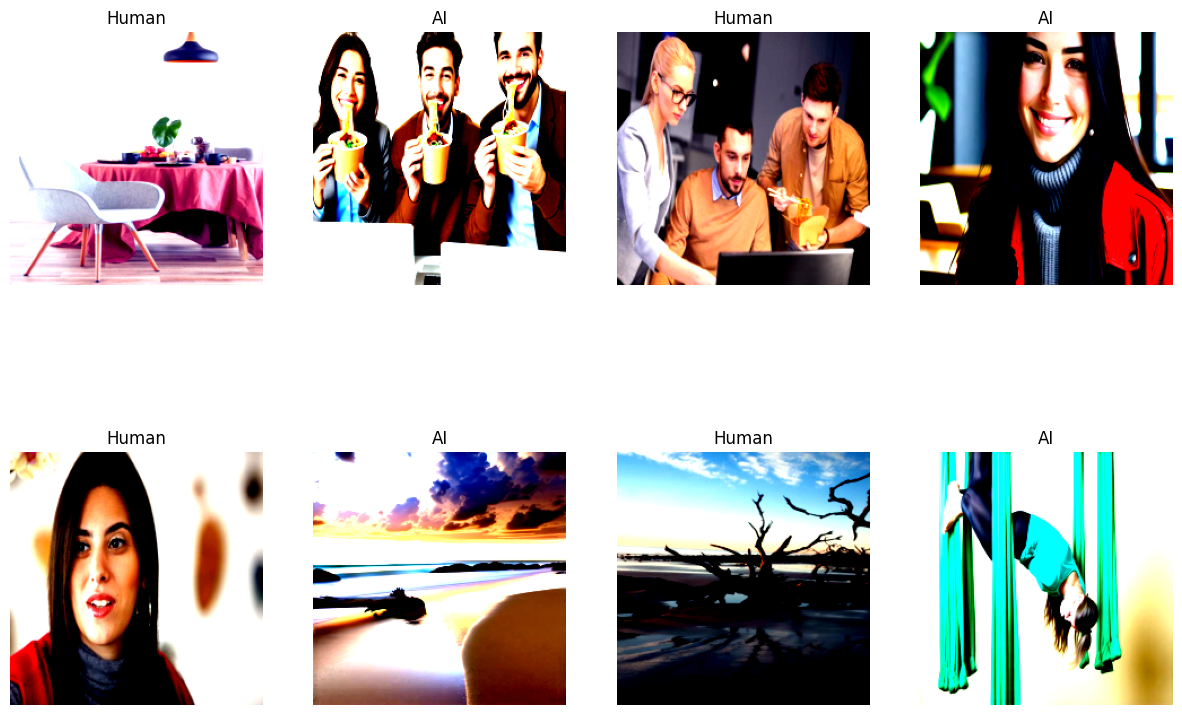

In [17]:
# Visualize Images
show_images(test_loader, n_rows=2, n_cols=4)

# Modeling

In [18]:
import torch
import torch.nn as nn
from timm import create_model
import timm

In [19]:
class ViTMaxVitFusion(nn.Module):
    def __init__(self, num_classes=1):
        super(ViTMaxVitFusion, self).__init__()

        # Load MaxViT (for example: base model)
        self.maxvit = create_model("maxvit_base_tf_224", pretrained=True, num_classes=0)
        maxvit_out = self.maxvit.num_features

        # Load ConvNeXt (or Swin, as secondary model)
        self.convnext = create_model("convnext_large", pretrained=True, num_classes=0)
        convnext_out = self.convnext.num_features

        # Global Average Pooling
        self.global_avg_pooling_maxvit = nn.AdaptiveAvgPool1d(1)
        self.global_avg_pooling_convnext = nn.AdaptiveAvgPool1d(1)

        # Fusion + Classifier
        self.feature_fusion = nn.Sequential(
            nn.BatchNorm1d(maxvit_out + convnext_out),
            nn.Linear(maxvit_out + convnext_out, 1024),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.4),
        )

        self.decoder = nn.Sequential(
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x_maxvit = self.maxvit(x)
        x_convnext = self.convnext(x)

        # Apply global avg pooling
        x_maxvit = self.global_avg_pooling_maxvit(x_maxvit.unsqueeze(2)).view(x_maxvit.size(0), -1)
        x_convnext = self.global_avg_pooling_convnext(x_convnext.unsqueeze(2)).view(x_convnext.size(0), -1)

        # Concatenate and classify
        x_combined = torch.cat((x_maxvit, x_convnext), dim=1)
        x_fused = self.feature_fusion(x_combined)
        return self.decoder(x_fused)


In [20]:
# maxvit_models = timm.list_models('*maxvit*')

# # Print the list to see the correct model names.
# print(maxvit_models)

In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ViTMaxVitFusion(num_classes=1).to(device)

model.safetensors:   0%|          | 0.00/479M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/791M [00:00<?, ?B/s]

In [22]:
# Freeze backbone layers
for param in model.convnext.parameters():
    param.requires_grad = False
for param in model.maxvit.parameters():
    param.requires_grad = False

In [23]:
# Optionally unfreeze last few layers
for param in list(model.maxvit.parameters())[-10:]:
    param.requires_grad = True

for param in list(model.convnext.parameters())[-10:]:
    param.requires_grad = True

In [24]:
optimizer = torch.optim.AdamW(
    [p for p in model.parameters() if p.requires_grad],
    lr=1e-4, weight_decay=1e-2
)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)
criterion = nn.BCEWithLogitsLoss().to(device)

In [25]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from tqdm import tqdm
from torch.amp import GradScaler, autocast

In [26]:
def train_model(model, train_loader, val_loader, optimizer, criterion, scheduler, device, epochs=10, patience=3):
    scaler = GradScaler("cuda")

    best_val_loss = float('inf')
    no_improve = 0
    train_losses, val_losses = [], []
    val_f1_scores, val_roc_aucs = [], []

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        y_true_train, y_pred_train = [], []

        loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} [Train]", leave=False)
        for images, labels in loop:
            images, labels = images.to(device), labels.to(device).unsqueeze(1).float()
            optimizer.zero_grad()

            with autocast("cuda"):
                outputs = model(images)
                loss = criterion(outputs, labels)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            train_loss += loss.item() * images.size(0)
            y_true_train.extend(labels.detach().cpu().numpy().flatten())
            y_pred_train.extend((torch.sigmoid(outputs).detach().cpu().numpy() > 0.5).astype(int).flatten())

            acc = accuracy_score(y_true_train, y_pred_train)
            loop.set_postfix(loss=loss.item(), acc=acc)


        train_loss /= len(train_loader.dataset)
        train_acc = accuracy_score(y_true_train, y_pred_train)

        # Validation Phase
        model.eval()
        val_loss = 0.0
        y_true_val, y_pred_val = [], []

        with torch.no_grad():
            for images, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs} [Val]", leave=False):
                images, labels = images.to(device), labels.to(device).unsqueeze(1).float()

                with autocast(device_type='cuda'):
                    outputs = model(images)
                    loss = criterion(outputs, labels)

                val_loss += loss.item() * images.size(0)
                y_true_val.extend(labels.detach().cpu().numpy().flatten())
                y_pred_val.extend((torch.sigmoid(outputs).detach().cpu().numpy() > 0.5).astype(int).flatten())

        val_loss /= len(val_loader.dataset)
        val_acc = accuracy_score(y_true_val, y_pred_val)
        f1 = f1_score(y_true_val, y_pred_val)
        roc_auc = roc_auc_score(y_true_val, y_pred_val)

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        val_f1_scores.append(f1)
        val_roc_aucs.append(roc_auc)

        print(f"Epoch [{epoch+1}/{epochs}] "
              f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | "
              f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f} | "
              f"Val F1: {f1:.4f} | Val ROC AUC: {roc_auc:.4f}")

        scheduler.step()

        # Early Stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'best_model_weights.pth')
            torch.save(model, 'best_model.pth')
            print("Model improved and saved!")
            no_improve = 0
        else:
            no_improve += 1
            if no_improve >= patience:
                print(f"Early stopping triggered at epoch {epoch+1}")
                break


In [27]:
train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    criterion=criterion,
    scheduler=scheduler,
    device=device,
    epochs=10,
    patience=3
)


Epoch [1/10] Train Loss: 0.1138 | Train Acc: 0.9545 | Val Loss: 0.1253 | Val Acc: 0.9587 | Val F1: 0.9600 | Val ROC AUC: 0.9587
Model improved and saved!


Epoch [2/10] Train Loss: 0.0545 | Train Acc: 0.9798 | Val Loss: 0.0756 | Val Acc: 0.9774 | Val F1: 0.9776 | Val ROC AUC: 0.9774
Model improved and saved!


Epoch [3/10] Train Loss: 0.0364 | Train Acc: 0.9873 | Val Loss: 0.0706 | Val Acc: 0.9741 | Val F1: 0.9745 | Val ROC AUC: 0.9741
Model improved and saved!


Epoch [4/10] Train Loss: 0.0275 | Train Acc: 0.9903 | Val Loss: 0.0944 | Val Acc: 0.9732 | Val F1: 0.9738 | Val ROC AUC: 0.9732


Epoch [5/10] Train Loss: 0.0220 | Train Acc: 0.9925 | Val Loss: 0.0686 | Val Acc: 0.9789 | Val F1: 0.9791 | Val ROC AUC: 0.9789
Model improved and saved!


Epoch [6/10] Train Loss: 0.0157 | Train Acc: 0.9948 | Val Loss: 0.0779 | Val Acc: 0.9804 | Val F1: 0.9806 | Val ROC AUC: 0.9804


Epoch [7/10] Train Loss: 0.0122 | Train Acc: 0.9957 | Val Loss: 0.0591 | Val Acc: 0.9805 | Val F1: 0.9807 | Val ROC AUC: 0.9805
Model improved and saved!


Epoch [8/10] Train Loss: 0.0095 | Train Acc: 0.9969 | Val Loss: 0.0806 | Val Acc: 0.9786 | Val F1: 0.9790 | Val ROC AUC: 0.9786


Epoch [9/10] Train Loss: 0.0075 | Train Acc: 0.9975 | Val Loss: 0.0665 | Val Acc: 0.9809 | Val F1: 0.9811 | Val ROC AUC: 0.9809


Epoch [10/10] Train Loss: 0.0066 | Train Acc: 0.9980 | Val Loss: 0.0628 | Val Acc: 0.9829 | Val F1: 0.9831 | Val ROC AUC: 0.9829
Early stopping triggered at epoch 10


# Model Evaluation

In [28]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def evaluate_model(model, data_loader, device):
    model.eval()
    y_true, y_pred = [], []

    # Wrap data_loader with tqdm to show progress bar
    with torch.no_grad():
        for images, labels in tqdm(data_loader, desc="Evaluating", unit="batch"):
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            
            # Apply sigmoid if using BCEWithLogitsLoss
            if outputs.shape[-1] == 1:  
                outputs = torch.sigmoid(outputs)

            preds = (outputs > 0.5).int()

            y_true.extend(labels.cpu().numpy().flatten())
            y_pred.extend(preds.cpu().numpy().flatten())

    # Compute metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)

    # Display results
    print("\nEvaluation Results:")
    print(f"Internal Test Accuracy : {accuracy:.4f}")
    print(f"Precision             : {precision:.4f}")
    print(f"Recall                : {recall:.4f}")
    print(f"F1-Score              : {f1:.4f}")

    return y_true, y_pred


In [29]:
evaluate_model(model, test_loader, device)

Evaluating: 100%|██████████| 1000/1000 [03:51<00:00,  4.31batch/s]



Evaluation Results:
Internal Test Accuracy : 0.9827
Precision             : 0.9714
Recall                : 0.9947
F1-Score              : 0.9829


([0.0,
  1.0,
  0.0,
  1.0,
  0.0,
  1.0,
  0.0,
  1.0,
  0.0,
  1.0,
  0.0,
  1.0,
  0.0,
  1.0,
  0.0,
  1.0,
  0.0,
  1.0,
  0.0,
  1.0,
  0.0,
  1.0,
  0.0,
  1.0,
  0.0,
  1.0,
  0.0,
  1.0,
  0.0,
  1.0,
  0.0,
  1.0,
  0.0,
  1.0,
  0.0,
  1.0,
  0.0,
  1.0,
  0.0,
  1.0,
  0.0,
  1.0,
  0.0,
  1.0,
  0.0,
  1.0,
  0.0,
  1.0,
  0.0,
  1.0,
  0.0,
  1.0,
  0.0,
  1.0,
  0.0,
  1.0,
  0.0,
  1.0,
  0.0,
  1.0,
  0.0,
  1.0,
  0.0,
  1.0,
  0.0,
  1.0,
  0.0,
  1.0,
  0.0,
  1.0,
  0.0,
  1.0,
  0.0,
  1.0,
  0.0,
  1.0,
  0.0,
  1.0,
  0.0,
  1.0,
  0.0,
  1.0,
  0.0,
  1.0,
  0.0,
  1.0,
  0.0,
  1.0,
  0.0,
  1.0,
  0.0,
  1.0,
  0.0,
  1.0,
  0.0,
  1.0,
  0.0,
  1.0,
  0.0,
  1.0,
  0.0,
  1.0,
  0.0,
  1.0,
  0.0,
  1.0,
  0.0,
  1.0,
  0.0,
  1.0,
  0.0,
  1.0,
  0.0,
  1.0,
  0.0,
  1.0,
  0.0,
  1.0,
  0.0,
  1.0,
  0.0,
  1.0,
  0.0,
  1.0,
  0.0,
  1.0,
  0.0,
  1.0,
  0.0,
  1.0,
  0.0,
  1.0,
  0.0,
  1.0,
  0.0,
  1.0,
  0.0,
  1.0,
  0.0,
  1.0,
  0.0,
  1.0,
  0.0,

# Submission

In [30]:
# If your test CSV doesn't have labels
sub_test_paths = test_csv.index.tolist() 

In [31]:
# sub_test_paths

In [32]:
# --- Test Dataset Class (matching your training dataset style) ---
class TestDataset(Dataset):
    def __init__(self, file_paths, root_dir, transform=None):
        self.file_paths = file_paths
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        # If file_paths is a pandas Series, use .iloc; if list, index directly
        img_name = self.file_paths.iloc[idx] if hasattr(self.file_paths, "iloc") else self.file_paths[idx]
        img_path = os.path.join(self.root_dir, img_name)

        image = Image.open(img_path).convert("RGB")  # Use PIL for consistency
        if self.transform:
            image = self.transform(image)

        return image

In [33]:
test_dataset_submission = TestDataset(
    sub_test_paths,       # same structure as train file_paths
    main_dir,             # root folder where images are stored
    transform=val_test_transform  # same normalization as validation
)

test_loader_submission = DataLoader(
    test_dataset_submission,
    batch_size=BATCH_SIZE,
    shuffle=False
)

In [34]:
# Make predictions
model.eval()
all_preds = []

with torch.no_grad():
    for images in tqdm(test_loader_submission, desc="Predicting", unit="batch"):
        images = images.to(device)
        outputs = model(images)

        # Apply sigmoid if using BCEWithLogitsLoss (for binary classification)
        if outputs.shape[-1] == 1:
            outputs = torch.sigmoid(outputs)

        preds = (outputs > 0.5).int()
        all_preds.extend(preds.cpu().numpy().flatten())

Predicting: 100%|██████████| 693/693 [06:02<00:00,  1.91batch/s]


In [35]:
submission = pd.DataFrame({
    "id": sub_test_paths,     # Explicit column
    "label": all_preds
})

submission.to_csv("submission.csv", index=False)
print(submission.head())

                                                  id  label
0  test_data_v2/1a2d9fd3e21b4266aea1f66b30aed157.jpg      1
1  test_data_v2/ab5df8f441fe4fbf9dc9c6baae699dc7.jpg      0
2  test_data_v2/eb364dd2dfe34feda0e52466b7ce7956.jpg      0
3  test_data_v2/f76c2580e9644d85a741a42c6f6b39c0.jpg      0
4  test_data_v2/a16495c578b7494683805484ca27cf9f.jpg      0
